In [4]:
%matplotlib inline
%load_ext jupyternotify
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import scipy.integrate
import plotly.graph_objects as go
import time
t1 = time.time()

<IPython.core.display.Javascript object>

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


## Description of the STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiency_of_guess()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot_for_guess(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.krotov_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses of intensity with phase and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Krotov's method](https://qucontrol.github.io/krotov/v1.2.1/07_krotovs_method.html).

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on three variables, the end time of the stokes pulse and start time of pump pulse and the two photon detuning ($\delta$).

In [38]:
class N_STIRAP():
    def __init__(self,n,Omega,E,T,t,W,Delta,Gamma,nsteps=500):
        self.Omega = np.array(Omega)
        self.E = E
        self.T = T
        self.t = np.array(t)*T
        self.W = np.array(W)*T
        self.n = n
        self.Delta = np.append(0,np.array(Delta) - (0.5j*np.array(Gamma)))
        self.nsteps = nsteps
    
    def _Omega(self,t,i):
        return self.Omega[i]*krotov.shapes.blackman(t, t_start=self.t[i], t_stop=self.t[i]+self.W[i])
    
    def _hamiltonian(self,t,i=None,j=None):
        H0 = np.diag(self.Delta)
        Omegas = np.array([self._Omega(t,i) for i in range(self.n-1)])
        H = 0.5*(np.diagflat(Omegas,k=-1) + np.diagflat(Omegas,k=1))
        if i == None and j == None:
            return H0+H
        return (H0+H)[i,j]
    
    def _final_result(self):
        psi = np.array([int(i==0) for i in range(self.n)])
        tlist = np.linspace(0,self.T,self.nsteps)
        psi_list = [psi]
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi_list[-1])
            psi_list.append(psi)
        eff = (np.absolute(psi[self.n-1])**2)/(np.linalg.norm(psi)**2)
        return np.array(psi_list),tlist,eff
    
    def efficiency_of_guess(self):
        return self._final_result()[2]
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return -1*self.efficiency_of_guess()
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        psiT,t,_ = self._final_result()
        fig, ax = plt.subplots()
        norm = np.linalg.norm(psiT,axis=1)
        for i in range(self.n):
            ax.plot(t, np.absolute(psiT[:,i])**2, label=str(i+1))
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        for i in range(self.n-1):
            pulse = np.array([self._Omega(t,i) for t in tlist])
            plt.plot(tlist, pulse,label=str(i+1)+" to "+str(i+2))
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
        if print_results:
            print(opti)
        self.tS2 = opti.x[0]*self.T
        self.tP1 = opti.x[1]*self.T
        if print_pulse:
            self.plot_for_guess()

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 20 $\mu s$. The single photon detuning is $\Delta = 1$ GHz and there is two photon resonance.

In [19]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)

Efficiency = 0.9974487356102066


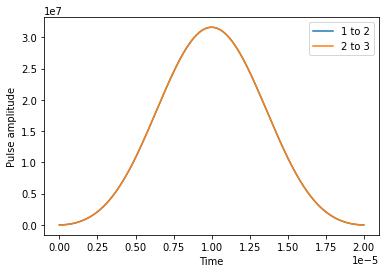

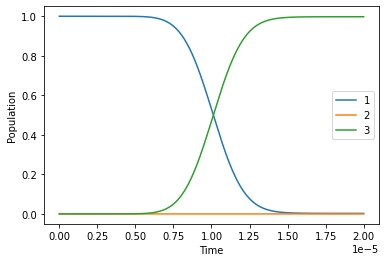

In [39]:
try_1 = N_STIRAP(n=3,Omega=[31.6*10**6,31.6*10**6],E=[0,hfs,F_3],T=20*10**(-6),t=[0,0],W=[1,1],Delta=[10**9,0],Gamma=[0*10**6,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency_of_guess()))
try_1.plot_for_guess()

Efficiency = 0.9122837846461387


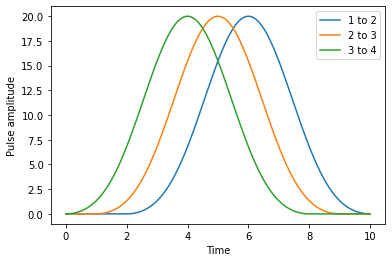

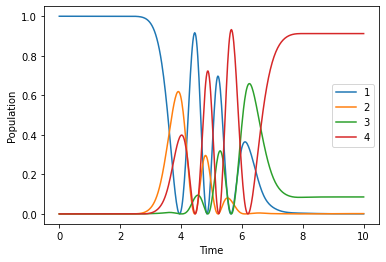

In [49]:
try_2 = N_STIRAP(n=4,Omega=[20,20,20],E=[0,5,10,15],T=10,t=[0.2,0.1,0],W=[0.8,0.8,0.8],Delta=[0,0,0],Gamma=[0,0,0],nsteps=500)
print("Efficiency = "+str(try_2.efficiency_of_guess()))
try_2.plot_for_guess()

In [13]:
np.append(0,vector)

array([0.+0.j, 0.+3.j, 4.+0.j, 6.+0.j, 4.+0.j, 0.+3.j, 6.+0.j])